In [79]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Implement a CNN for MNIST in Pytorch

### Load and Preprocess the MNIST Dataset

#### Data Transformation

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to mean 0.5 and std 0.5 for MNIST
])

#### Load Data

In [81]:
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

#### Train, Validation & Test

In [82]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### CNN Model

In [83]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3)  # Conv layer with 8 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=3)  # Conv layer with 8 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 10 * 10, 128)  # Fully connected layer with 64 units
        self.fc2 = nn.Linear(128, 10)         # Output layer with 10 units
        
    def _forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + ReLU + Pool
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + ReLU + Pool             # Output layer
        return x
    
    def __getforwardsize__(self):
        x = torch.randn(1, 1, 28, 28) 
        return self._forward(x).shape
    
    def forward(self, x):
        self._forward(x)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 10 * 10)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))  # First fully connected layer + ReLU
        x = self.fc2(x)
        return x  # No softmax; CrossEntropyLoss applies softmax

# Instantiate model, define loss function and optimizer
model = CNN()

outputsize = model.__getforwardsize__()
output_size = np.prod(outputsize)
print("Output size:", (output_size))

Output size: 6400


Define Loss Function and Optimizer

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train and Test the Model

#### Training Function

In [85]:
def train_model(num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    total_train_time = time.time() - start_time
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, total_train_time

#### Train and Validate the model

In [86]:
num_epochs = 5
train_loss_history, val_loss_history, train_acc_history, val_acc_history, total_train_time = train_model(num_epochs)

Epoch 1/5, Train Loss: 0.1942, Train Acc: 94.09%, Val Loss: 0.0618, Val Acc: 97.97%
Epoch 2/5, Train Loss: 0.0548, Train Acc: 98.29%, Val Loss: 0.0484, Val Acc: 98.54%
Epoch 3/5, Train Loss: 0.0365, Train Acc: 98.86%, Val Loss: 0.0359, Val Acc: 98.87%
Epoch 4/5, Train Loss: 0.0277, Train Acc: 99.18%, Val Loss: 0.0359, Val Acc: 98.95%
Epoch 5/5, Train Loss: 0.0203, Train Acc: 99.33%, Val Loss: 0.0435, Val Acc: 98.73%


#### Plot Training and Validation loss

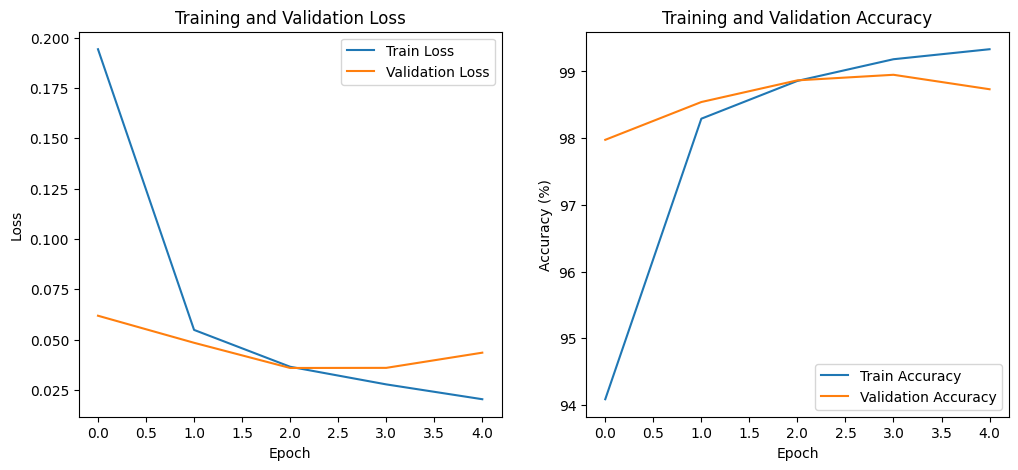

In [87]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Save the model

In [88]:
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

#### Testing Function

In [89]:
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total:.2f}%')

# Load and test the model
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
test_model()

C:\Users\NaderZadeh\AppData\Local\Temp\ipykernel_11084\836420763.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_cnn_model.pth')

Accuracy of the model on test images: 98.60%
